In [166]:
import pickle as pk
import matplotlib.pylab as plt
import numpy as np
from numpy.linalg import norm
from math import sqrt, exp
%matplotlib nbagg
from PyKEP import *


In [146]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

We load the data file obtained from the optimization (in low-thrust) of many legs (GTOC7): 

ast1, ast2, $t_1$, $t_2$, $m^*$, $m_i$, $\Delta V^*$, $\Delta V$, $\Delta V_L$, $\Delta V_D$, $m^*_L$, $m^*_D$

We want to learn $\Delta V$ (i.e. the final mass) from the rest (known quickly using a Lambert solver and Damon model). The ast1 and ast2 ids can be used with the gtoc7 asteroids to know the orbitalparameters.


In [147]:
a = pk.load(open("learn.pkl","rb"))
print("DATA = ", a)
print("ONE ROW = ", a[0])

DATA =  [[ 11830.          10256.          10962.60236546 ...,   4906.74618359
    2544.20354737   1476.60103897]
 [  6846.           6073.          11098.51009776 ...,   6586.44735414
    1251.97554234    775.87757295]
 [ 15646.           8853.          10472.90296903 ...,   4091.14474818
    2968.07001635   1992.14286758]
 ..., 
 [  4952.          14339.          10326.68381981 ...,   4057.38011553
    2788.37388882   1485.32852058]
 [ 12662.          11131.           9791.69375163 ...,   4885.57653231
    2874.03260757   2312.48314192]
 [ 14007.           7294.          10253.04425878 ...,   4728.99722101
    2062.81669447   1294.33686228]]
ONE ROW =  [ 11830.          10256.          10962.60236546  11220.6581701
   1427.64964893   1352.56164444   4894.91224655   4225.21779204
   2629.03746956   4906.74618359   2544.20354737   1476.60103897]


### Visualizing the data

We plot the data with a high alpha as to show the data density. The plots are a result of knowledge in the domain, thus manual feature engineering ...

First we plot the starting mass (fraction w.r.t the maximual allowed $m^*$) vs the $\Delta V$ (fraction w.r.t. $\Delta V^*$). This last fraction is, essentially ,the duration of the coast arc. 1 -> no coast, 0-> full coast. 
We observe that no trajectory has a $\Delta V$ higher than the one relative to maxmum mass (obvious as that correspond to no coast arc), you thus cannot thrust for longer. A strange feature that should be discussed / checked is that many trajectories show no coast arc even if they are very light.

<IPython.core.display.Javascript object>


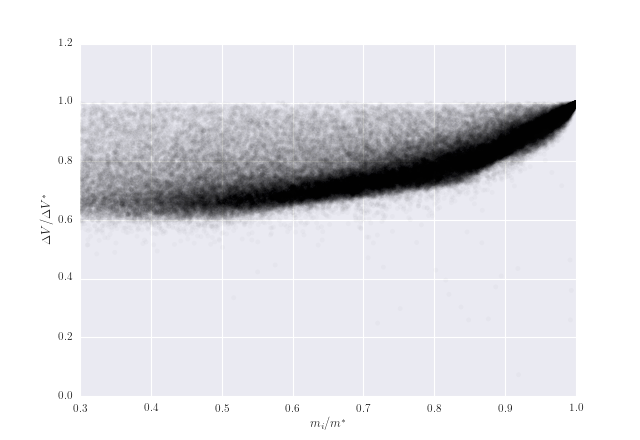

(0.3, 1)

In [148]:
plt.figure()
plt.scatter(  a[:,5]/a[:,4], a[:,7] / a[:,6], marker='o', alpha=0.02,edgecolor="none",c=np.array([a[:,5]  / max(a[:,8])]*3).transpose())
plt.xlabel("$ {m_i} / {m^*}$")
plt.ylabel("$ {\Delta V} / {\Delta V^*}$")
plt.xlim(0.3,1)

Second, we plot the starting mass (fraction w.r.t the maximual allowed $m^*$) vs the $\Delta V$ (fraction w.r.t. $\Delta V^L$). 
We observe a few low-thrust trajectories with a $\Delta V$ which is improving w.r.t Lambert. These are not extremely frequent, but correspond to cases where a two impulse orbital transfer is not optimal

<IPython.core.display.Javascript object>


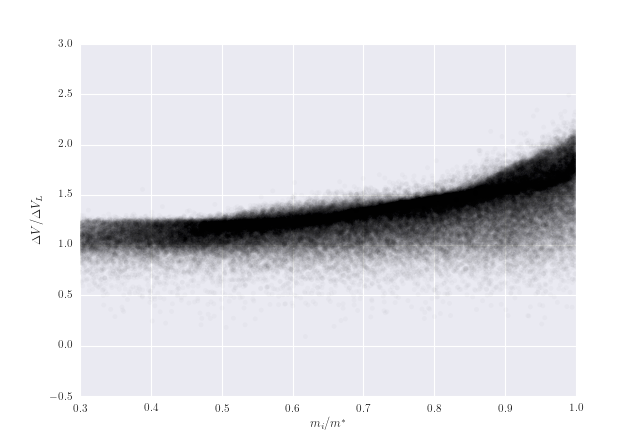

(0.3, 1)

In [149]:
plt.figure()
plt.scatter(  a[:,5]/a[:,4], a[:,7] / a[:,8], marker='o', alpha=0.02, edgecolor="none", c=np.array([a[:,5]  / max(a[:,8])]*3).transpose())
plt.xlabel("$ {m_i} / {m^*}$")
plt.ylabel("$ {\Delta V} / {\Delta V_L}$")
plt.xlim(0.3,1)

Third, we plot the starting mass (fraction w.r.t the maximual allowed $m^*$) vs $\Delta V - \Delta V_L$ (fraction w.r.t. $\Delta V^*$). This third plot shows the highes correlation between variables.

<IPython.core.display.Javascript object>


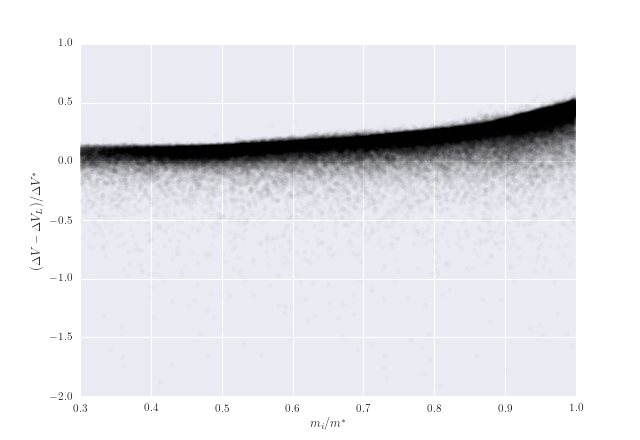

In [150]:
plt.figure()
plt.scatter(  a[:,5]/a[:,4], (a[:,7]-a[:,8]) / (a[:,6]), marker='o', alpha=0.02,edgecolor="none", c=np.array([a[:,5]  / max(a[:,8])]*3).transpose())
plt.xlim(0.3,1)
plt.ylim(-2,1)
plt.xlabel("$ {m_i} / {m^*}$")
plt.ylabel("$ {(\Delta V - \Delta V_L} ) / {\Delta V^*}$")

<IPython.core.display.Javascript object>


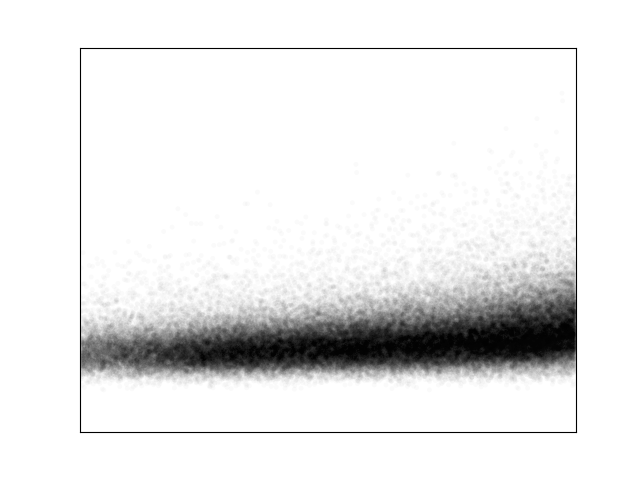

In [7]:
plt.figure()
plt.scatter(  a[:,5]/a[:,4],  ( 1. - np.exp(-a[:,7] / 3000 / 9.80665)), marker='o', alpha=0.02,edgecolor="none", c=np.array([a[:,5]  / max(a[:,8])]*3).transpose())
plt.xlim(0.3,1)
#plt.ylim(-2,1)
plt.xlabel("$ ({m_i} / {m^*}) $")
plt.ylabel("$ (m_i - m_f ) / m_i $")

## Now we do some machine learning

From each line ast1, ast2, $t_1$, $t_2$, $m^*$, $m_i$, $\Delta V^*$, $\Delta V$, $\Delta V_L$, $\Delta V_D$, $m^*_L$, $m^*_D$

As attributes we use $t_2-t_1$, $m^*_D$, $m_i$, $\Delta V^*_D$, $\Delta V_L$, $m^*_L$, as these are the ones we can compute at the cost of one lambert problem solution


In [199]:
X = list()
#X_queries = list()
y = list()
for row in a:
    a1 = planet.gtoc7(int(row[0])).osculating_elements(epoch(0))[0] 
    a2 = planet.gtoc7(int(row[1])).osculating_elements(epoch(0))[0]
    e1 = planet.gtoc7(int(row[0])).osculating_elements(epoch(0))[1] 
    e2 = planet.gtoc7(int(row[1])).osculating_elements(epoch(0))[1]
    r1,v1 = planet.gtoc7(int(row[0])).eph(row[2]) # MJD2000 assumed in data
    r2,v2 = planet.gtoc7(int(row[1])).eph(row[2])
    h1 = np.cross(r1,v1)
    h2 = np.cross(r2,v2)
    cost = np.dot(h1,h2) / norm(h1) / norm(h2)
    X.append(np.array((row[3] - row[2], row[5], row[11], row[9], row[8], row[10], cost, a1, a2, norm(r1), norm(r2))))
    #X_queries.append(np.array((row[3] - row[2], row[11], row[5], row[9], row[8], row[10])))
    y.append(row[5] * ( 1 - np.exp(-row[7] / 3000 / 9.80665)))
X = np.array(X)
y = np.array(y)
#X_queries = np.array(X_queries)

In [200]:
print(X[0])
print(y[0])


[  2.58055805e+02   1.35256164e+03   1.47660104e+03   4.90674618e+03
   2.62903747e+03   2.54420355e+03   9.99065966e-01   3.85282150e+11
   3.69510555e+11   4.34730211e+11   3.97833479e+11]
180.946956378


In [201]:
# Split data in train and test data
# A random permutation, to split the data randomly
N = 30000
np.random.seed(0)
indices = np.random.permutation(len(X))
traj_X_train = X[indices[:-N]]
traj_y_train = y[indices[:-N]]
traj_X_test  = X[indices[-N:]]
traj_y_test  = y[indices[-N:]]
#traj_X_query_test = X_queries[indices[-N:]]

### Decision trees

In [202]:
#from sklearn import linear_model
#regr = linear_model.LinearRegression()
from sklearn import tree
regr = tree.DecisionTreeRegressor()
regr.fit(traj_X_train, traj_y_train)

# The mean square error
print("RMSE", sqrt(np.mean((regr.predict(traj_X_test)-traj_y_test)**2)))
#print("RMSE (queries)", sqrt(np.mean((regr.predict(traj_X_query_test)-traj_y_test)**2)))


# Explained variance score: 1 is perfect prediction
# and 0 means that there is no linear relationship
# between X and Y.
print("EVS", regr.score(traj_X_test, traj_y_test))

RMSE 18.607381909374627
EVS 0.923853431434


### Ensemble

In [203]:
#from sklearn import linear_model
#regr = linear_model.LinearRegression()
from sklearn import ensemble
regr = ensemble.RandomForestRegressor()
regr.fit(traj_X_train, traj_y_train)

# The mean square error
print("RMSE", sqrt(np.mean((regr.predict(traj_X_test)-traj_y_test)**2)))
#print("RMSE (queries)", sqrt(np.mean((regr.predict(traj_X_query_test)-traj_y_test)**2)))


# Explained variance score: 1 is perfect prediction
# and 0 means that there is no linear relationship
# between X and Y.
print("EVS", regr.score(traj_X_test, traj_y_test))

RMSE 13.61655305275891
EVS 0.959223104393


<IPython.core.display.Javascript object>


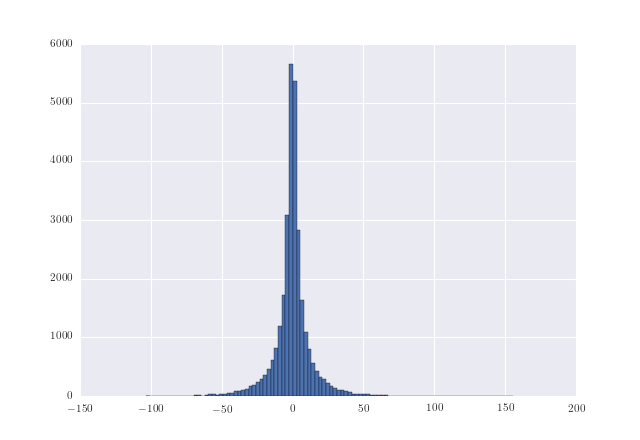

In [204]:
plt.figure()
h = plt.hist(regr.predict(traj_X_test)-traj_y_test, 100)
#plt.xlabel("error (Kg) on the test set")
plt.axes()

Lets see what would happen if, instead we predict the final mass as:

$$
m_f = m_i * exp(\frac{-\Delta V_L}{I_{sp}g_0)
$$

In [205]:
lambert_prediction = a[indices[-N:], 5] * (1 - np.exp( - a[indices[-N:], 8] / 3000 / 9.80665) )
# The mean square error
print("RMSE", sqrt(np.mean((lambert_prediction-traj_y_test)**2)))

RMSE 43.08023290457927


<IPython.core.display.Javascript object>


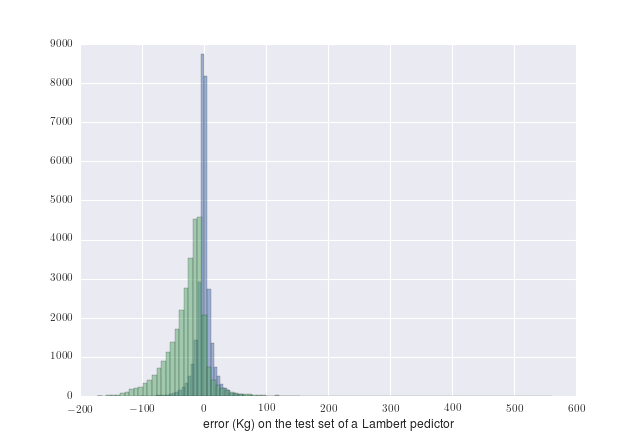

In [206]:
plt.figure()
h = plt.hist(regr.predict(traj_X_test)-traj_y_test, 50, alpha=0.5)
h = plt.hist(lambert_prediction-traj_y_test, 100, alpha=0.5)

plt.xlabel("error (Kg) on the test set of a Lambert pedictor")